# Reconhecimento Facial

Como exemplo de aplicação, tentar resolver o problema de reconhecimento facial.
Utilizar um conjunto de dados formado por milhares de fotos coletadas de diversas figuras públicas, está incluído em Scikit_Learn

In [15]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

In [7]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=60)

print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Representar graficamente algumas das fotos, para saber com o que estamos trabalhando.

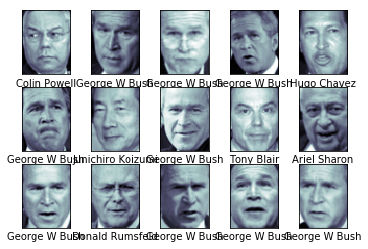

In [8]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
xlabel=faces.target_names[faces.target[i]])

Cada imagem tem [62 × 47] ou quase 3.000 pixels.

É possível prosseguir usando simplesmente cada valor de pixel como uma característica, mas geralmente é mais eficaz usar algum tipo de pré-processador para extrair características mais significativas. Aqui, vamos usar uma análise de componentes principais, PCA, para extrair 150 componentes fundamentais para alimentar nosso classificador SVM. 

Faremos o split em treinamento e teste para poder avaliar o classificador.

In [16]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Podemos treinar o modelo PCA sobre os dados de treinamento para reduzir as dimensões.

In [10]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)

Reduzimos as dimensões do conjunto de treinamento com PCA

In [23]:
model_pca = pca.fit(Xtrain)
X_train_pca = model_pca.transform(Xtrain)

In [24]:
X_train_pca.shape

(1011, 150)

In [25]:
Xtrain.shape

(1011, 2914)

Por fim, podemos usar validação cruzada para explorar uma "rede" de combinações de parâmetros.
Aqui, vamos ajustar C (que controla a dureza da margem) e gama (que controla o tamanho da base radial do núcleo da função), e determinar o melhor modelo:

In [20]:
from sklearn.model_selection import cross_val_score
svc_C = [1, 5, 10, 50]
svc_gamma = [0.0001, 0.0005, 0.001, 0.005]
for c in svc_C:
    for g in svc_gamma:
        model_svc = SVC(kernel='rbf', class_weight='balanced', C=c, gamma = g)
        print (np.mean(cross_val_score(model_svc,X_train_pca,ytrain,cv=5)),' gamma:',g,' C:',c)

0.100189405618  gamma: 0.0001  C: 1
0.598617402481  gamma: 0.0005  C: 1
0.792381531276  gamma: 0.001  C: 1
0.793390512111  gamma: 0.005  C: 1
0.700416178845  gamma: 0.0001  C: 5
0.798326812717  gamma: 0.0005  C: 5
0.801257705578  gamma: 0.001  C: 5
0.810141693383  gamma: 0.005  C: 5
0.800389662774  gamma: 0.0001  C: 10
0.795340824332  gamma: 0.0005  C: 10
0.788394245771  gamma: 0.001  C: 10
0.81113198653  gamma: 0.005  C: 10
0.790370566524  gamma: 0.0001  C: 50
0.779530935225  gamma: 0.0005  C: 50
0.789418884394  gamma: 0.001  C: 50
0.81113198653  gamma: 0.005  C: 50


Os valores ideais caem em direção ao centro da nossa rede de possíveis parâmetros. Se eles caírem nas bordas, devemos ampliar a rede para termos certeza de que encontramos o verdadeiro ideal.

Agora, com este modelo validado de forma cruzada, podemos prever as tags dos dados de teste que o modelo ainda não viu:

In [26]:
model_svc_optimo = SVC(kernel='rbf', class_weight='balanced', C=10, gamma = 0.005)

Agora ajustamos o modelo ideal com todos os dados de treinamento:

In [27]:
model_svc_optimo.fit(X_train_pca,ytrain)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Previsão sobre dados não observados

In [28]:
# Primeiro passamos os dados de teste pelo mesmo processo de redução de dimensões
X_test_pca = model_pca.transform(Xtest)

In [29]:
yfit = model_svc_optimo.predict(X_test_pca)

Vamos ver algumas das imagens de teste junto com seus valores previstos

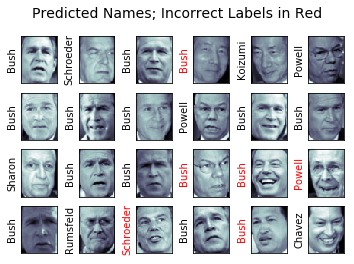

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
color='black' if yfit[i] == ytest[i] else 'red')fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

A partir desta pequena amostra, nosso estimador ideal erroneamente indicou apenas duas faces.
Podemos obter uma melhor percepção do desempenho de nosso estimador usando o relatório de classificação, que enumera as estatísticas de recuperação por tag:

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, yfit)

0.83976261127596441

In [32]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.80      0.86        15
     Colin Powell       0.79      0.94      0.86        68
  Donald Rumsfeld       0.88      0.68      0.76        31
    George W Bush       0.80      0.96      0.87       126
Gerhard Schroeder       0.94      0.70      0.80        23
      Hugo Chavez       1.00      0.45      0.62        20
Junichiro Koizumi       1.00      0.67      0.80        12
       Tony Blair       0.97      0.76      0.85        42

      avg / total       0.86      0.84      0.83       337



Também poderíamos mostrar a matriz de confusão entre essas classes.
Isso nos ajuda a ter uma ideia de quais tags podem ser as mais confusas para o estimador.

/home/digitalhouse/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/digitalhouse/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


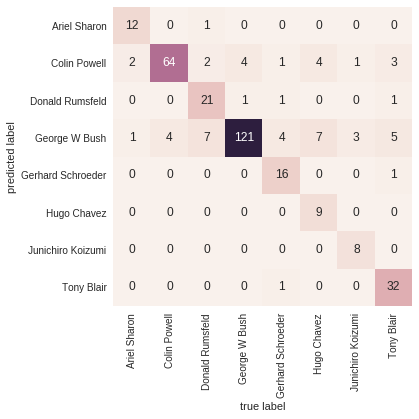

In [33]:
import seaborn as sns; sns.set()


from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=faces.target_names,yticklabels=faces.target_names)plt.xlabel('true label')
plt.ylabel('predicted label');

Para uma tarefa de reconhecimento facial no mundo real, em que as fotos não são pré-cortadas em grades convenientes, a única diferença no esquema de classificação facial é a seleção de características: você precisaria usar um algoritmo mais sofisticado para encontrar as faces e extrair características que são independentes da pixilação. Para este tipo de aplicação, uma boa opção é usar o OpenCV.org, que, entre outras coisas, inclui implementações pré-treinadas de ferramentas de última geração para extração de características para imagens em geral e faces em particular.